In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"What can you tell about Max Verstappen's first World Championship?", name="Model")]
messages.append(HumanMessage(content=f"I feel that the stewards were unfair towards Lewis Hamilton, possibly because they didn't want a black guy becoming an eight time world champion.",name="Lance"))
messages.append(AIMessage(content=f"No, I think it was a deserved win for Max, as it was Lewis's decision to stay out with the hard tyres.", name="Model"))
messages.append(HumanMessage(content=f"If you put it like that, then that sounds fair.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

What can you tell about Max Verstappen's first World Championship?
================================ Human Message =================================
Name: Lance

I feel that the stewards were unfair towards Lewis Hamilton, possibly because they didn't want a black guy becoming an eight time world champion.
================================== Ai Message ==================================
Name: Model

No, I think it was a deserved win for Max, as it was Lewis's decision to stay out with the hard tyres.
================================ Human Message =================================
Name: Lance

If you put it like that, then that sounds fair.


In [2]:
import os, getpass
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-mini")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [4]:
result

AIMessage(content="It's great to approach these discussions with an open mind! Formula 1 races often hinge on complex strategic decisions, and both driver performance and team calls play crucial roles. Max Verstappen's first World Championship in 2021 was certainly hard-fought, with many memorable moments throughout the season. If you'd like, I can share more details about that season or particular races!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 105, 'total_tokens': 179, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_c064fdde7c', 'id': 'chatcmpl-CRH32BD1NLCR7gunKZa3ZCauGpYsY', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b2c09814-5b1c-4517-a5ca-b82d89685a7

In [5]:
result.response_metadata

{'token_usage': {'completion_tokens': 74,
  'prompt_tokens': 105,
  'total_tokens': 179,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4.1-mini-2025-04-14',
 'system_fingerprint': 'fp_c064fdde7c',
 'id': 'chatcmpl-CRH32BD1NLCR7gunKZa3ZCauGpYsY',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

In [6]:
def decide_winner(a: int, b: int) -> int:
    """Checks which F1 driver has the highest points and declare the winner.

    Args:
        a: first driver points
        b: second driver points
    """
    if a > b:
        return a
    elif a < b:
        return b

llm_with_tools = llm.bind_tools([decide_winner])

In [7]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"Who is the world champion if Max Verstappen has 255 points, and Oscar Piastry has 331 points", name="Lance")])

In [8]:
tool_call.tool_calls

[{'name': 'decide_winner',
  'args': {'a': 255, 'b': 331},
  'id': 'call_9f76CQceYFdaKdIvYCsBuPs8',
  'type': 'tool_call'}]

In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [10]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [11]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [12]:
# Initial state
initial_messages = [AIMessage(content="Hello! What do you want to know about Formula 1?", name="Model"),
                    HumanMessage(content="I'm want to know all the glory about Sebastian Vettel.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. Which season specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! What do you want to know about Formula 1?', additional_kwargs={}, response_metadata={}, name='Model', id='5bd2b2cf-8d42-4f58-9356-d63583af166e'),
 HumanMessage(content="I'm want to know all the glory about Sebastian Vettel.", additional_kwargs={}, response_metadata={}, name='Lance', id='bf815a78-364f-48fe-a2b4-70cf957aaf04'),
 AIMessage(content='Sure, I can help with that. Which season specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='87fdbe6b-fce2-4421-91f7-4b2765078426')]

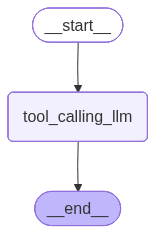

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages = graph.invoke({"messages": HumanMessage(content="Hey there!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hey there!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [15]:
messages = graph.invoke({"messages": HumanMessage(content="Who is the world champion if Sebastian Vettel has 589 points and Lance Stroll has 12 points", name="Lance")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Who is the world champion if Sebastian Vettel has 589 points and Lance Stroll has 12 points
================================== Ai Message ==================================
Tool Calls:
  decide_winner (call_iV9zV78uVJfI1caPHcs8KsFk)
 Call ID: call_iV9zV78uVJfI1caPHcs8KsFk
  Args:
    a: 589
    b: 12
